## Chapter 4. Improving Embeddings with Biased Random Walks in Node2Vec

Node2Vec은 DeepWalk의 수행 과정에서의 Random Walk와 Word2Vec을 동일하게 활용하지만 균일한 분포를 가진 노드 분포를 갖는다.

### Defining Neiborhood

- 이웃 노드를 정의하는 것은 직관적으로 시작 노드에 가까운 것으로 생각하지만 그래프 데이터 구조에서의 "Close(가까움)"는 문맥적으로 다를 수 있다.
- 이웃 노드를 탐색하기 위해 두 가지 Sampling 전략을 활용 가능하다.
- 연결되어 있는 주변 노드를 탐색하거나 반대로 이전에 인접하지 않은 노드를 선택하는 방법이 있다.

### DFS와 BFS의 관점에서 본 이웃 노드의 해석
- 이웃 노드를 정의할 때 BFS는 노드 주변의 로컬 네트워크에 초점을 둔다.
- DFS는 보다 거시적인 관점에서 네트워크 구조의 유사성을 확인할 수 있다.
==> BFS는 인접한 노드를 탐색하기 때문에 구조적 동등성에 부합하지만 DFS는 멀리 떨어진 노드를 샘플링할 수 있어 동질성이 떨어지는 노드를 강조한다.

결과적으로, 그래프 구조에서 동질성을 확인하기 위해 인접 노드를 확인하는 작업과 떨어지는 노드 모두 고려할 필요성이 있다. 때문에, 구조적 동등성과 동질성 모두를 결합한 방식을 활용해야 한다.

## Node2Vec

Node2Vec의 두가지 성질에 의해서 이웃 노드를 정의한다.
- 이전 노드와 멀리 있는 노드(DFS)
- 이전 노드와 가까운 노드(BFS)

##### Biased Random Wlak :그래프에서 특정 유형의 경로를 더 자주 탐색하도록 편향을 주는 방식

Biased Random Walk 원리

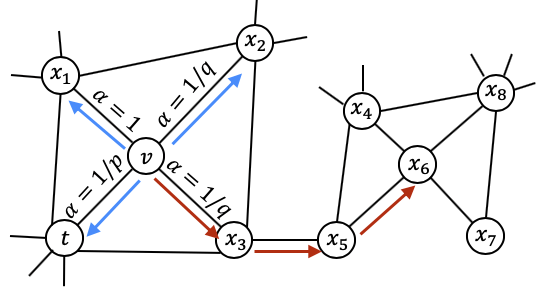

- p값: 이전 노드로 돌아가는 확률이다. p값은 현재 노드의 이전 노드로 돌아가는 것을 선호하는 정도를 나타낸다 즉, p값이 높을수록 이전 노드로 돌아가는 확률이 낮아진다. p값이 클수록 특정 새로운 노드를 탐색하는 경향이 크다. 이는 구조적 동등성을 고려하여 노드 간의 구조적 유사성을 강조하는 역할을 한다.


- q값: q 값이 높을수록 이전 노드에 가까운 노드에 집중하며 BFS와 유사한 형태를 나타낸다. 이는 이전 노드와 가까운 이웃 노드에 더 많은 가중치를 두어 탐색하는 특성을 나타낸다. q값이 클수록 동질성을 고려하여 비슷한 특성을 가진 노드를 방문하는 경향이 있다.

※ DeepWalk의 경우 p와 q 모두 1인 Node2Vec의 사례이다.

In [1]:
import networkx as nx
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

c:\Users\mmm06\anaconda3\envs\Deep_laerning\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


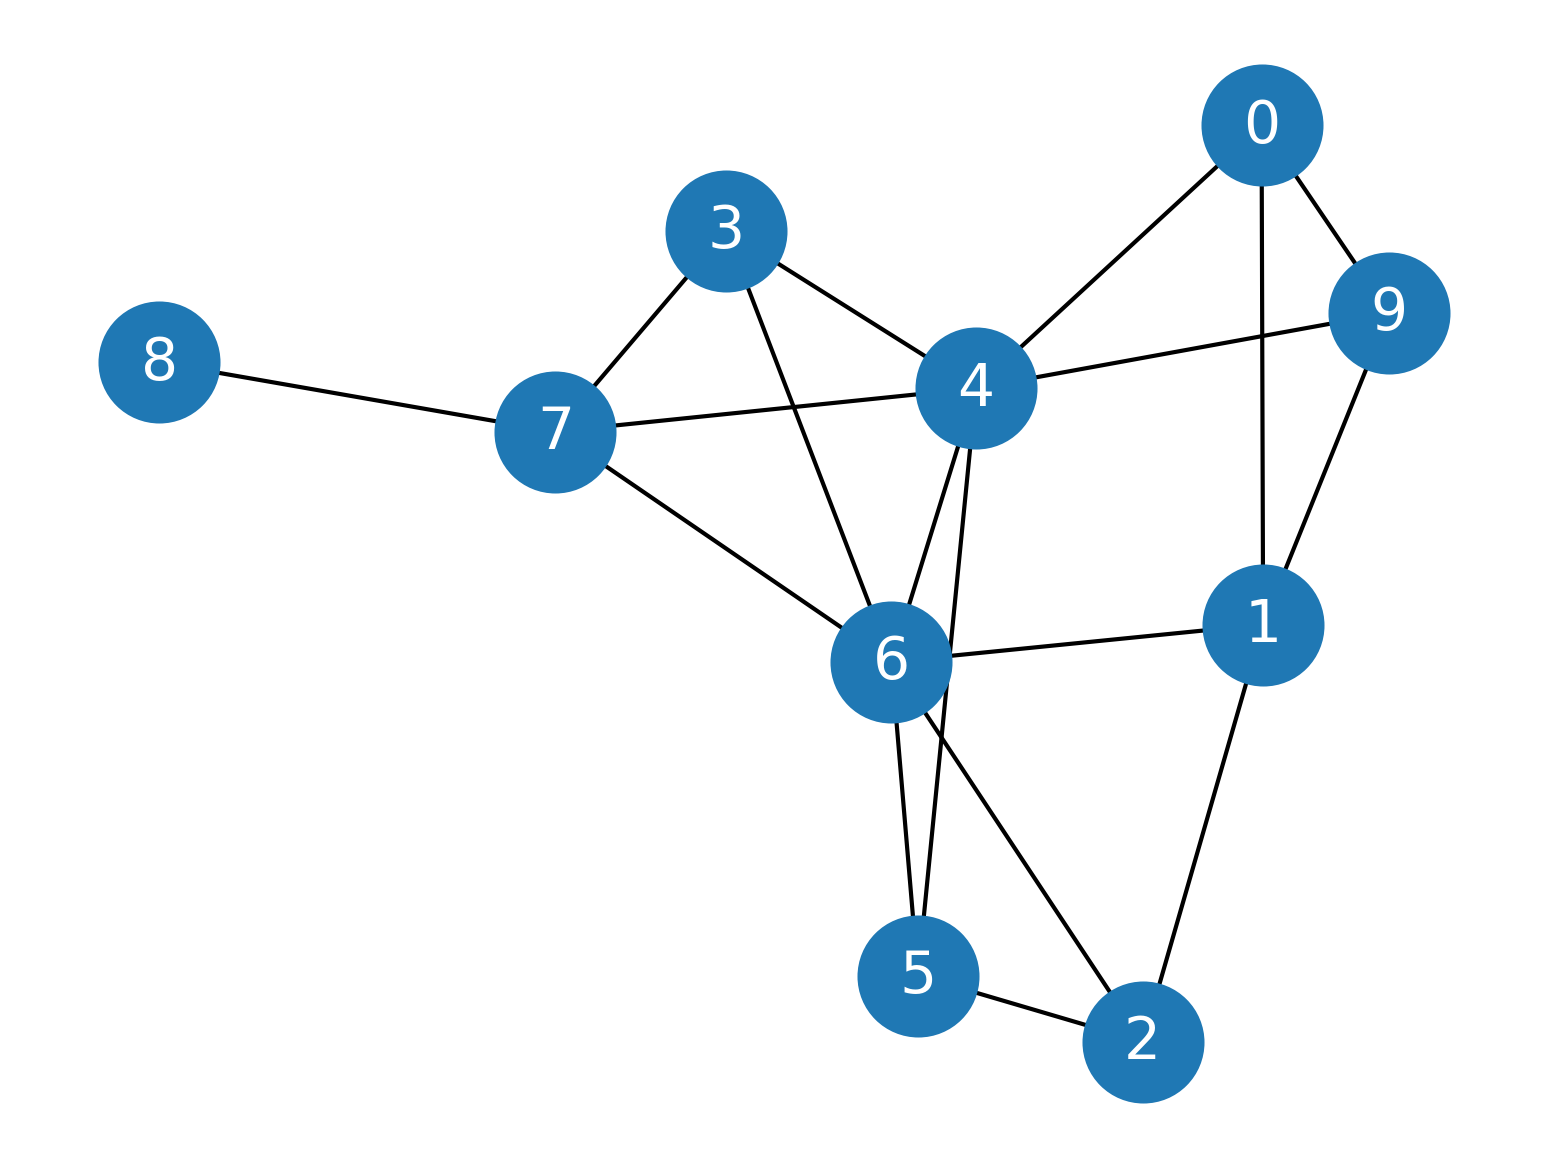

In [2]:
plt.figure(dpi =300)
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G,seed=0),
                 cmap='coolwarm',
                 node_size=800,
                 font_size=14,
                 font_color='white')

In [3]:
for node in G.nodes():
    print(f"node {node + 1} neighbor: ",list(G.neighbors(node)))

node 1 neighbor:  [1, 4, 9]
node 2 neighbor:  [0, 2, 6, 9]
node 3 neighbor:  [1, 5, 6]
node 4 neighbor:  [4, 6, 7]
node 5 neighbor:  [0, 3, 5, 6, 7, 9]
node 6 neighbor:  [2, 4, 6]
node 7 neighbor:  [1, 2, 3, 4, 5, 7]
node 8 neighbor:  [3, 4, 6, 8]
node 9 neighbor:  [7]
node 10 neighbor:  [0, 1, 4]


In [4]:
def next_node(previous, current, p, q):
    neighbors = list(G.neighbors(current))
    alphas = []

    for neighbor in neighbors:
        if neighbor == previous:
            alpha = 1/p
        elif G.has_edge(neighbor, previous):
            alpha = 1
        else:
            alpha = 1/q
        alphas.append(alpha)
        probs = [alpha / sum(alphas) for alpha in alphas]
    next = np.random.choice(neighbors, size = 1, p = probs)[0]

    return next

In [5]:
def random_walk(start, length, p, q):
    walk = [start]

    for i in range(length):
        cur_node = walk[-1]
        prev_node = walk[-2] if len(walk) > 1 else None # 초기 시작 노드의 경우
        next = next_node(prev_node, cur_node, p, q)
        walk.append(next)
    
    return [str(x) for x in walk]

모든 인접 노드의 전환 확률이 동일하기 때문에 무작위 결과가 도출됨을 확인할 수 있다. $p = 1$, $q = 1$를 통해 DeepWalk 알고리즘을 재현할 수 있다. 

In [6]:
random_walk(0, 8, p=1, q=1)

['0', '4', '7', '6', '4', '5', '4', '5', '6']

bias term을 이전 노드로 복귀할 확률을 높일 $q = 10$로 설정

In [7]:
random_walk(0, 8, p=1, q=10)

['0', '9', '1', '9', '1', '9', '1', '0', '1']

$p = 10$을 주어 시작 노드로 돌아가지 않는 Random Walk 결과 확인

In [8]:
random_walk(0, 8, p=10, q=1)

['0', '1', '9', '4', '7', '8', '7', '4', '6']

## Implementing Node2Vec

In [9]:
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

G = nx.karate_club_graph()

labels = []

for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

In [10]:
walks = []

for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10, 1, 1))

In [11]:
node2vec = Word2Vec(walks,
                    hs=1, # Hierarchical softmax
                    sg=1, # Skip-gram
                    vector_size=100,
                    window=10,
                    workers=2,
                    min_count=1,
                    seed=0)

node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)

train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
train_mask_str = [str(x) for x in train_mask]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
test_mask_str = [str(x) for x in test_mask]
labels = np.array(labels)

In [12]:
clf = RandomForestClassifier(random_state=0)
clf.fit(node2vec.wv[train_mask_str], labels[train_mask])

y_pred = clf.predict(node2vec.wv[test_mask_str])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Node2Vec accuracy = {acc*100:.2f}%')

Node2Vec accuracy = 100.00%


## Building a movie RecSys

In [13]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')
        
from collections import defaultdict
import pandas as pd

from node2vec import Node2Vec

In [14]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [15]:
movies = pd.read_csv('ml-100k/u.item', sep='|',usecols=range(2), names=['movie_id', 'title'],encoding='latin-1')
movies

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [16]:
ratings = ratings[ratings.rating >= 4]
ratings

,user_id,movie_id,rating,unix_timestamp
5,298,474,4,884182806
7,253,465,5,891628467
11,286,1014,5,879781125
12,200,222,5,876042340
16,122,387,5,879270459
...,...,...,...,...
99988,421,498,4,892241344
99989,495,1091,4,888637503
99990,806,421,4,882388897
99991,676,538,4,892685437


In [18]:
# defaultdict을 통해 자동적으로 결측 값을 무시하는 딕셔너리를 생성
# 링크가 존재하는 영화를 저장하기 위해 사용
pairs = defaultdict(int)
 
# 유저 아이디를 기준으로 본 영화 집계계
for group in ratings.groupby("user_id"):
    # List of IDs of movies rated by the current user
    user_movies = list(group[1]["movie_id"])
 
    # 두 가지 영화가 같이 보여진 경우 집계계
    for i in range(len(user_movies)):
        for j in range(i+1, len(user_movies)):
            pairs[(user_movies[i], user_movies[j])] += 1
            
G = nx.Graph()
 
# 노드 간 연결을 표현하기 위한 페어 노드(엣지 리스트) 생성성
for pair in pairs:
    movie1, movie2 = pair
    score = pairs[pair]
 
    
    if score >= 20:
        G.add_edge(movie1, movie2, weight=score)
 
print("Total number of graph nodes:", G.number_of_nodes())
print("Total number of graph edges:", G.number_of_edges())

Total number of graph nodes: 410
Total number of graph edges: 14936


In [19]:
G.edges

EdgeView([(61, 59), (59, 64), (59, 134), (59, 98), (59, 174), (59, 56), (59, 185), (59, 175), (59, 100), (59, 197), (59, 50), (59, 238), (59, 127), (59, 79), (59, 191), (59, 357), (59, 12), (59, 89), (59, 474), (59, 480), (59, 60), (59, 179), (59, 318), (33, 174), (33, 56), (33, 96), (33, 50), (33, 172), (174, 160), (174, 202), (174, 265), (174, 47), (174, 222), (174, 227), (174, 64), (174, 228), (174, 121), (174, 114), (174, 132), (174, 134), (174, 98), (174, 186), (174, 177), (174, 82), (174, 56), (174, 229), (174, 72), (174, 185), (174, 96), (174, 258), (174, 81), (174, 212), (174, 151), (174, 175), (174, 209), (174, 12), (174, 14), (174, 163), (174, 210), (174, 184), (174, 157), (174, 150), (174, 183), (174, 248), (174, 208), (174, 193), (174, 250), (174, 91), (174, 129), (174, 241), (174, 86), (174, 196), (174, 230), (174, 23), (174, 65), (174, 190), (174, 100), (174, 154), (174, 214), (174, 161), (174, 170), (174, 9), (174, 246), (174, 22), (174, 187), (174, 135), (174, 68), (174

In [20]:
node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, p=2, q=1, workers=1)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

def recommend(movie):
    movie_id = str(movies[movies.title == movie].movie_id.values[0])
    for id in model.wv.most_similar(movie_id)[:5]:
        title = movies[movies.movie_id == int(id[0])].title.values[0]
        print(f'{title}: {id[1]:.2f}')
 
recommend('Star Wars (1977)')    

Computing transition probabilities:   0%|          | 0/410 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:23<00:00,  8.68it/s]


Return of the Jedi (1983): 0.61
Raiders of the Lost Ark (1981): 0.55
Godfather, The (1972): 0.49
Indiana Jones and the Last Crusade (1989): 0.46
White Squall (1996): 0.44


## Pytorch geometry를 활용한 Node2Vec 구현(GPU 지원)

#### Gensim & Pytorch geometry의 구현 방식 차이
- Genism의 Node2Vec은 랜덤 워크 시퀀스(리스트)
- Pytorch Geometry의 경우 Node2Vec 입력이 엣지 인덱스(2D Tensor)
- Pytorch의 경우 명시적으로 간선 정보가 필요하며, 모델 내부에서 랜덤 워크를 생성한다,
- Gensim은 랜덤 워크를 외부에서 실행한 후에 모델의 입력으로 넣어줘야 한다.

In [21]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import Node2Vec


edge_idx = torch.tensor(list(G.edges)).t().contiguous() # 메모리 연속성을 고려하기 위한 contiguous()

# Node2Vec 모델 (GPU 지원)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [22]:
import multiprocessing as mp
ctx = mp.get_context('spawn')
mp.set_start_method('spawn', force=True)

In [26]:
node2vec = Node2Vec(edge_idx, 
                    embedding_dim=64, 
                    walk_length=20, # 랜덤 워크 길이
                    context_size=10, # skip-gram window 크기
                    walks_per_node=10, # 각 노드 강 할당되는 랜덤 워크 개수
                    p=2, # 이전 노드로 돌아갈 확률 제어(높을 수록 덜 돌아감)
                    q=1, # 그래프 탐색의 폭과 높이를 조절(높으면 로컬 탐색, 낮으면 글로벌 탐색색)
                    sparse=True, # True는 대규모 그래프에서 활용
                    num_negative_samples=5).to(device) # skip-gram의 negative sample 개수 정의의

# Optimizer
optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01) # learning rate가 너무 크면 loss가 줄지 않음
# data loader
loader = node2vec.loader(batch_size =128, shuffle=True, num_workers=0)

In [27]:
# 학습
def train():
    node2vec.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

In [28]:
for epoch in range(300):
    loss = train()
    print(f'Epoch: {epoch + 1:03d}, Loss: {loss:.4f}')

# 임베딩 추출
embeddings = node2vec.embedding.weight.data.cpu().numpy()

Epoch: 001, Loss: 32.6566
Epoch: 002, Loss: 27.9982
Epoch: 003, Loss: 24.1324
Epoch: 004, Loss: 21.0413
Epoch: 005, Loss: 18.5773
Epoch: 006, Loss: 16.4901
Epoch: 007, Loss: 14.8274
Epoch: 008, Loss: 13.4028
Epoch: 009, Loss: 12.2152
Epoch: 010, Loss: 11.2215
Epoch: 011, Loss: 10.3842
Epoch: 012, Loss: 9.7086
Epoch: 013, Loss: 9.1551
Epoch: 014, Loss: 8.7028
Epoch: 015, Loss: 8.3524
Epoch: 016, Loss: 8.0578
Epoch: 017, Loss: 7.8151
Epoch: 018, Loss: 7.6280
Epoch: 019, Loss: 7.4788
Epoch: 020, Loss: 7.3631
Epoch: 021, Loss: 7.2595
Epoch: 022, Loss: 7.1908
Epoch: 023, Loss: 7.1198
Epoch: 024, Loss: 7.0649
Epoch: 025, Loss: 7.0215
Epoch: 026, Loss: 6.9923
Epoch: 027, Loss: 6.9597
Epoch: 028, Loss: 6.9297
Epoch: 029, Loss: 6.9153
Epoch: 030, Loss: 6.9035
Epoch: 031, Loss: 6.8791
Epoch: 032, Loss: 6.8648
Epoch: 033, Loss: 6.8479
Epoch: 034, Loss: 6.8420
Epoch: 035, Loss: 6.8356
Epoch: 036, Loss: 6.8220
Epoch: 037, Loss: 6.8130
Epoch: 038, Loss: 6.8016
Epoch: 039, Loss: 6.7967
Epoch: 040, Lo

In [ ]:
# 유사한 영화 추천 함수
def recommend(movie, top_n=5):
    # 1. 입력된 영화의 movie_id 찾기
    movie_id = int(movies[movies.title == movie].movie_id.values[0])

    # 2. 모든 노드(영화)의 임베딩 가져오기
    embeddings = node2vec.embedding.weight.data

    # 3. 기준 영화의 임베딩
    target_emb = embeddings[movie_id].unsqueeze(0)

    # 4. 코사인 유사도 계산
    cosine_sim = F.cosine_similarity(target_emb, embeddings)

    # 5. 유사도 상위 top_n 노드 찾기 (자기 자신 제외)
    top_similar = torch.topk(cosine_sim, top_n + 1)
    similar_ids = top_similar.indices.tolist()
    similarity_scores = top_similar.values.tolist()

    # 6. 자기 자신 제외 후 추천 결과 출력
    for idx, score in zip(similar_ids, similarity_scores):
        if idx != movie_id:
            title = movies[movies.movie_id == idx].title.values[0]
            print(f'{title}: {score:.2f}')

# 영화 추천 실행
recommend('Star Wars (1977)')

torch.Size([1, 64])
Mighty Aphrodite (1995): 0.79
Three Colors: Red (1994): 0.79
Willy Wonka and the Chocolate Factory (1971): 0.78
Leaving Las Vegas (1995): 0.78
Lone Star (1996): 0.77
